# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer  

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

plt.style.use('ggplot')

# Data Preprcoessing

In [2]:
data = pd.read_csv("Reviews.csv")
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
data.drop(['ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time'], axis=1, inplace=True)
data.head()

,Id,Score,Summary,Text
0,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,2,Cough Medicine,If you are looking for the secret ingredient i...
4,5,5,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
data.shape

(568454, 4)

In [5]:
# STRATIFIED SAMPLING
train, test = train_test_split(data, test_size=0.9, stratify=data['Score'], random_state=42)
train.shape, test.shape

((56845, 4), (511609, 4))

In [6]:
df = pd.DataFrame(train)
df.head()

,Id,Score,Summary,Text
284989,284990,2,Amazon sent the wrong dressing,Apparently I am not the first customer to have...
323737,323738,5,Shepherd and Cattle Dog Love It!,We bought the large cube because of our 97lb. ...
273537,273538,5,Not difficult to get a refund if you were tric...,"First off I have no idea how good these ""pods""..."
481023,481024,5,Great Smoked paprika,I use the La Tienda Smoked Paprikas to make gr...
40183,40184,1,It will be thrown away. Looks like a weed.,I must have gotten the scraps. My tree was ab...


In [7]:
sample_txt = df['Text'].sample().values[0]
sample_txt

'My 9 year old terrier turns her nose up to most treats- human or dog- she is very picky! She lives these! The vet recommended these and they are cheaper on amazon. Win win!'

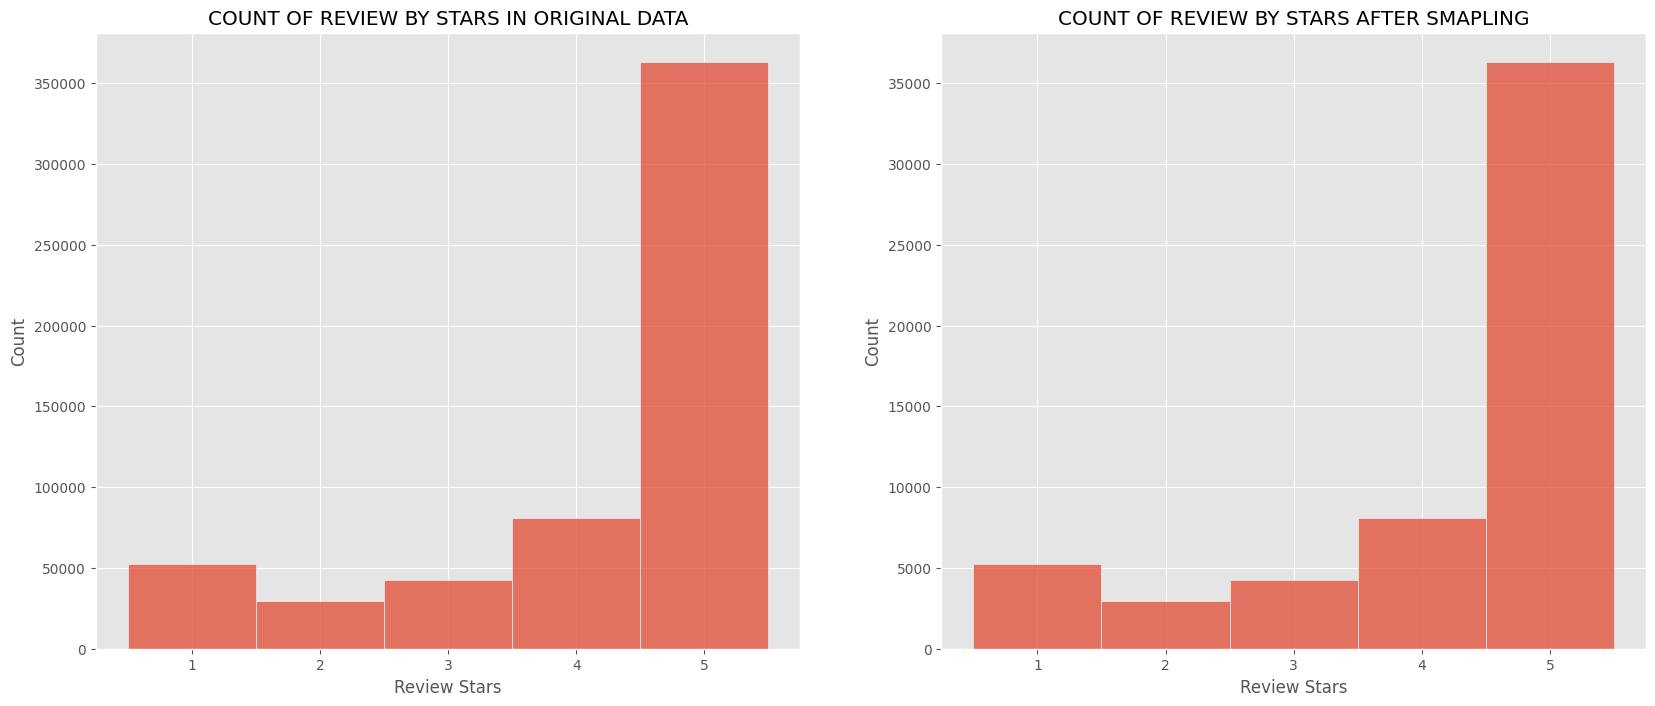

In [8]:
plt.figure(figsize=(20,8))

plt.subplot( 1, 2, 1)
sns.histplot( x='Score', data=data, binwidth=1, binrange=(0.5,5.5))
plt.title('COUNT OF REVIEW BY STARS IN ORIGINAL DATA')

plt.xlabel('Review Stars')
plt.xticks([1, 2, 3, 4, 5])

plt.subplot( 1, 2, 2)
sns.histplot( x='Score', data=df, binwidth=1, binrange=(0.5,5.5))
plt.title('COUNT OF REVIEW BY STARS AFTER SMAPLING')

plt.xlabel('Review Stars')
plt.xticks([1, 2, 3, 4, 5])

plt.show()

# Classifying Reviews using VADER Model

In [9]:
sia = SentimentIntensityAnalyzer()

In [10]:
sia.polarity_scores("This is delicious!")

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6114}

In [11]:
sia.polarity_scores("I am not happy with the service provided")

{'neg': 0.333, 'neu': 0.667, 'pos': 0.0, 'compound': -0.4585}

In [12]:
sample_txt

'My 9 year old terrier turns her nose up to most treats- human or dog- she is very picky! She lives these! The vet recommended these and they are cheaper on amazon. Win win!'

In [13]:
sia.polarity_scores(sample_txt)

{'neg': 0.0, 'neu': 0.708, 'pos': 0.292, 'compound': 0.8996}

In [14]:
res={}
for i, row in tqdm(df.iterrows(),total=len(df)):
    id, text = row['Id'], row['Text']
    res[id] = sia.polarity_scores(text)
    

  0%|          | 0/56845 [00:00<?, ?it/s]

In [15]:
vader = pd.DataFrame(res).T
vader.head()

,neg,neu,pos,compound
284990,0.093,0.907,0.000,-0.3570
323738,0.074,0.843,0.083,0.6474
273538,0.026,0.842,0.132,0.8439
481024,0.000,0.886,0.114,0.6249
40184,0.222,0.747,0.031,-0.9454


In [16]:
vader = vader.reset_index()
vader = vader.rename(columns={'index':'Id', 'neg':"vader_neg", 'neu':"vader_neu", 'pos':"vader_pos", 'compound':'vader_comp'})
vader.head()

,Id,vader_neg,vader_neu,vader_pos,vader_comp
0,284990,0.093,0.907,0.000,-0.3570
1,323738,0.074,0.843,0.083,0.6474
2,273538,0.026,0.842,0.132,0.8439
3,481024,0.000,0.886,0.114,0.6249
4,40184,0.222,0.747,0.031,-0.9454


In [17]:
vader = vader.merge(df, how='left', on='Id')
vader.head()

,Id,vader_neg,vader_neu,vader_pos,vader_comp,Score,Summary,Text
0,284990,0.093,0.907,0.000,-0.3570,2,Amazon sent the wrong dressing,Apparently I am not the first customer to have...
1,323738,0.074,0.843,0.083,0.6474,5,Shepherd and Cattle Dog Love It!,We bought the large cube because of our 97lb. ...
2,273538,0.026,0.842,0.132,0.8439,5,Not difficult to get a refund if you were tric...,"First off I have no idea how good these ""pods""..."
3,481024,0.000,0.886,0.114,0.6249,5,Great Smoked paprika,I use the La Tienda Smoked Paprikas to make gr...
4,40184,0.222,0.747,0.031,-0.9454,1,It will be thrown away. Looks like a weed.,I must have gotten the scraps. My tree was ab...


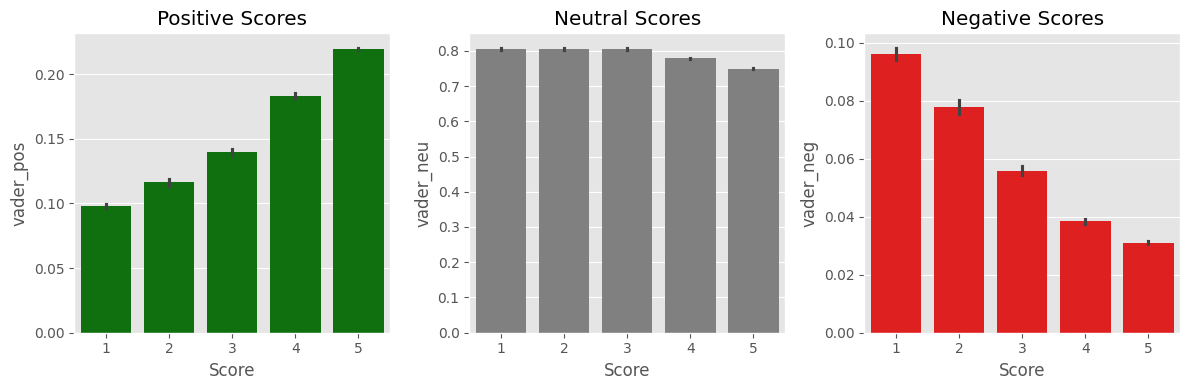

In [18]:
#Visualizing The Change In Scores With Respect To Star Ratings

plt.figure(figsize=(12,4))

plt.subplot( 1, 3, 1)
sns.barplot( data=vader, x='Score', y='vader_pos', color='green')
plt.title("Positive Scores")

plt.subplot( 1, 3, 2)
sns.barplot( data=vader, x='Score', y='vader_neu', color='grey')
plt.title("Neutral Scores")

plt.subplot( 1, 3, 3)
sns.barplot( data=vader, x='Score', y='vader_neg', color='red')
plt.title("Negative Scores")

plt.tight_layout()
plt.show()

In [19]:
vader.head()

,Id,vader_neg,vader_neu,vader_pos,vader_comp,Score,Summary,Text
0,284990,0.093,0.907,0.000,-0.3570,2,Amazon sent the wrong dressing,Apparently I am not the first customer to have...
1,323738,0.074,0.843,0.083,0.6474,5,Shepherd and Cattle Dog Love It!,We bought the large cube because of our 97lb. ...
2,273538,0.026,0.842,0.132,0.8439,5,Not difficult to get a refund if you were tric...,"First off I have no idea how good these ""pods""..."
3,481024,0.000,0.886,0.114,0.6249,5,Great Smoked paprika,I use the La Tienda Smoked Paprikas to make gr...
4,40184,0.222,0.747,0.031,-0.9454,1,It will be thrown away. Looks like a weed.,I must have gotten the scraps. My tree was ab...


In [20]:
preds=[]

for i, row in tqdm(vader.iterrows(), total=len(vader)):
    comp_score = row['vader_comp']
    if comp_score<0:
        preds.append([row['Id'], "Negative"])
    elif comp_score<=0.4:
        preds.append([row['Id'], "Neutral"])
    else:
        preds.append([row['Id'], "Positive"])

  0%|          | 0/56845 [00:00<?, ?it/s]

In [21]:
vader_preds = pd.DataFrame(preds)
vader_preds.columns=['Id','Vader Prediction']
vader_preds.head()

,Id,Vader Prediction
0,284990,Negative
1,323738,Positive
2,273538,Positive
3,481024,Positive
4,40184,Negative


In [22]:
vader = vader.merge(vader_preds, how='left', on='Id')
vader.head()

,Id,vader_neg,vader_neu,vader_pos,vader_comp,Score,Summary,Text,Vader Prediction
0,284990,0.093,0.907,0.000,-0.3570,2,Amazon sent the wrong dressing,Apparently I am not the first customer to have...,Negative
1,323738,0.074,0.843,0.083,0.6474,5,Shepherd and Cattle Dog Love It!,We bought the large cube because of our 97lb. ...,Positive
2,273538,0.026,0.842,0.132,0.8439,5,Not difficult to get a refund if you were tric...,"First off I have no idea how good these ""pods""...",Positive
3,481024,0.000,0.886,0.114,0.6249,5,Great Smoked paprika,I use the La Tienda Smoked Paprikas to make gr...,Positive
4,40184,0.222,0.747,0.031,-0.9454,1,It will be thrown away. Looks like a weed.,I must have gotten the scraps. My tree was ab...,Negative


# Classifying Reviews using ROBERTA Pretrained Model

In [23]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [24]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [25]:
from scipy.special import softmax

def roberta_polarity_scores(text):
  encoded_txt = tokenizer(text,return_tensors='pt')
  output = model(**encoded_txt)
    
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {'roberta_neg':scores[0],'roberta_neu':scores[1],'roberta_pos':scores[2]}
  return scores_dict

In [26]:
sia.polarity_scores(sample_txt)

{'neg': 0.0, 'neu': 0.708, 'pos': 0.292, 'compound': 0.8996}

In [27]:
roberta_polarity_scores(sample_txt)

{'roberta_neg': 0.05984972, 'roberta_neu': 0.19453622, 'roberta_pos': 0.745614}

In [28]:
res={}
for i ,row in tqdm(df.iterrows(),total=len(df)):
  try:
    id, text = row['Id'], row['Text'] 
    res[id] = roberta_polarity_scores(text)
  except Exception:
        pass

  0%|          | 0/56845 [00:00<?, ?it/s]

In [29]:
roberta = pd.DataFrame(res).T
roberta = roberta.reset_index().rename(columns={'index':'Id'})
roberta.head()

,Id,roberta_neg,roberta_neu,roberta_pos
0,284990,0.827688,0.156197,0.016115
1,323738,0.181574,0.404189,0.414237
2,273538,0.097084,0.327709,0.575206
3,481024,0.001986,0.038633,0.959381
4,40184,0.922129,0.071149,0.006722


In [30]:
result = roberta.merge(vader, how='left', on='Id')
result.head()

,Id,roberta_neg,roberta_neu,roberta_pos,vader_neg,vader_neu,vader_pos,vader_comp,Score,Summary,Text,Vader Prediction
0,284990,0.827688,0.156197,0.016115,0.093,0.907,0.000,-0.3570,2,Amazon sent the wrong dressing,Apparently I am not the first customer to have...,Negative
1,323738,0.181574,0.404189,0.414237,0.074,0.843,0.083,0.6474,5,Shepherd and Cattle Dog Love It!,We bought the large cube because of our 97lb. ...,Positive
2,273538,0.097084,0.327709,0.575206,0.026,0.842,0.132,0.8439,5,Not difficult to get a refund if you were tric...,"First off I have no idea how good these ""pods""...",Positive
3,481024,0.001986,0.038633,0.959381,0.000,0.886,0.114,0.6249,5,Great Smoked paprika,I use the La Tienda Smoked Paprikas to make gr...,Positive
4,40184,0.922129,0.071149,0.006722,0.222,0.747,0.031,-0.9454,1,It will be thrown away. Looks like a weed.,I must have gotten the scraps. My tree was ab...,Negative


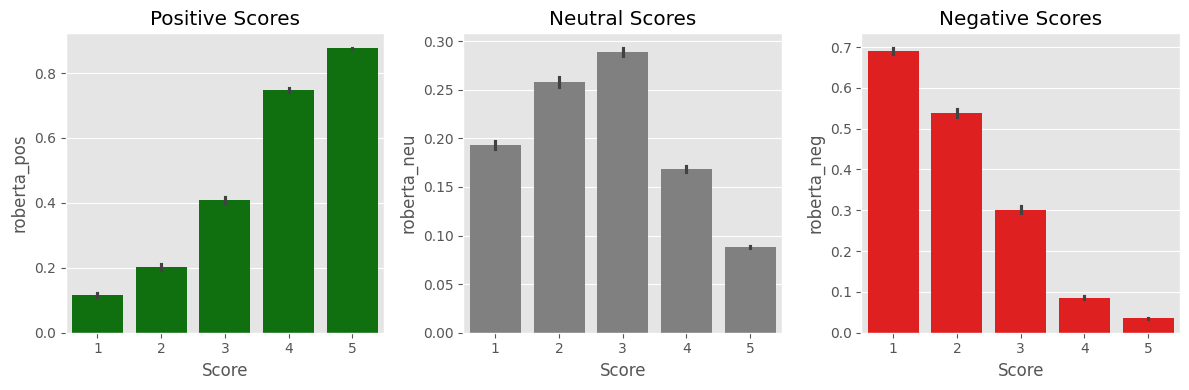

In [31]:
#Visualizing The Change In Scores With Respect To Star Ratings

plt.figure(figsize=(12,4))

plt.subplot( 1, 3, 1)
sns.barplot( data=result, x='Score', y='roberta_pos', color='green')
plt.title("Positive Scores")

plt.subplot( 1, 3, 2)
sns.barplot( data=result, x='Score', y='roberta_neu', color='grey')
plt.title("Neutral Scores")

plt.subplot( 1, 3, 3)
sns.barplot( data=result, x='Score', y='roberta_neg', color='red')
plt.title("Negative Scores")

plt.tight_layout()
plt.show()

In [32]:
preds=[]
for i, row in tqdm(roberta.iterrows(), total=len(roberta)):
    compute_scores = [row['roberta_neg'],row['roberta_neu'],row['roberta_pos']]
    if max(compute_scores)==compute_scores[0]:
        preds.append([row['Id'], "Negative"])
    elif max(compute_scores)==compute_scores[1]:
        preds.append([row['Id'], "Neutral"])
    else:
        preds.append([row['Id'], "Positive"])

  0%|          | 0/56239 [00:00<?, ?it/s]

In [33]:
roberta_preds = pd.DataFrame(preds)
roberta_preds.columns=['Id','Roberta Prediction']
roberta_preds.head()

,Id,Roberta Prediction
0,284990.0,Negative
1,323738.0,Positive
2,273538.0,Positive
3,481024.0,Positive
4,40184.0,Negative


In [34]:
result = result.merge(roberta_preds, how='left', on='Id')
result.head()

,Id,roberta_neg,roberta_neu,roberta_pos,vader_neg,vader_neu,vader_pos,vader_comp,Score,Summary,Text,Vader Prediction,Roberta Prediction
0,284990,0.827688,0.156197,0.016115,0.093,0.907,0.000,-0.3570,2,Amazon sent the wrong dressing,Apparently I am not the first customer to have...,Negative,Negative
1,323738,0.181574,0.404189,0.414237,0.074,0.843,0.083,0.6474,5,Shepherd and Cattle Dog Love It!,We bought the large cube because of our 97lb. ...,Positive,Positive
2,273538,0.097084,0.327709,0.575206,0.026,0.842,0.132,0.8439,5,Not difficult to get a refund if you were tric...,"First off I have no idea how good these ""pods""...",Positive,Positive
3,481024,0.001986,0.038633,0.959381,0.000,0.886,0.114,0.6249,5,Great Smoked paprika,I use the La Tienda Smoked Paprikas to make gr...,Positive,Positive
4,40184,0.922129,0.071149,0.006722,0.222,0.747,0.031,-0.9454,1,It will be thrown away. Looks like a weed.,I must have gotten the scraps. My tree was ab...,Negative,Negative


# Analayzing the Classifications of VADER and ROBERTA Pretrained Models

In [35]:
result['Vader Prediction'].value_counts()

Vader Prediction
Positive    45645
Negative     6064
Neutral      4530
Name: count, dtype: int64

In [36]:
result['Roberta Prediction'].value_counts()

Roberta Prediction
Positive    43597
Negative     8637
Neutral      4005
Name: count, dtype: int64

In [37]:
preds=[]
for i, rows in tqdm(result.iterrows(),total=len(result)):
    vader_pred = rows['Vader Prediction']
    roberta_pred = rows['Roberta Prediction']
    
    if vader_pred!=roberta_pred:
        preds.append([rows['Id'], rows['Score'], vader_pred, roberta_pred])

  0%|          | 0/56239 [00:00<?, ?it/s]

In [38]:
predictions = pd.DataFrame(preds)
predictions.columns = [ 'Id', 'Score', 'Vader Prediction', 'Roberta Prediction']
predictions.head()

,Id,Score,Vader Prediction,Roberta Prediction
0,44566,5,Negative,Positive
1,481104,4,Positive,Negative
2,492068,2,Positive,Negative
3,283941,1,Negative,Neutral
4,139799,3,Positive,Neutral


In [39]:
print( "Number of Mis-matched Predictions are", len(predictions) )

Number of Mis-matched Predictions are 11139


In [40]:
predictions.sample(5)

,Id,Score,Vader Prediction,Roberta Prediction
4694,321682,5,Neutral,Positive
3755,126523,3,Neutral,Positive
1392,189939,5,Negative,Neutral
2687,468779,3,Neutral,Negative
6620,2726,3,Neutral,Negative


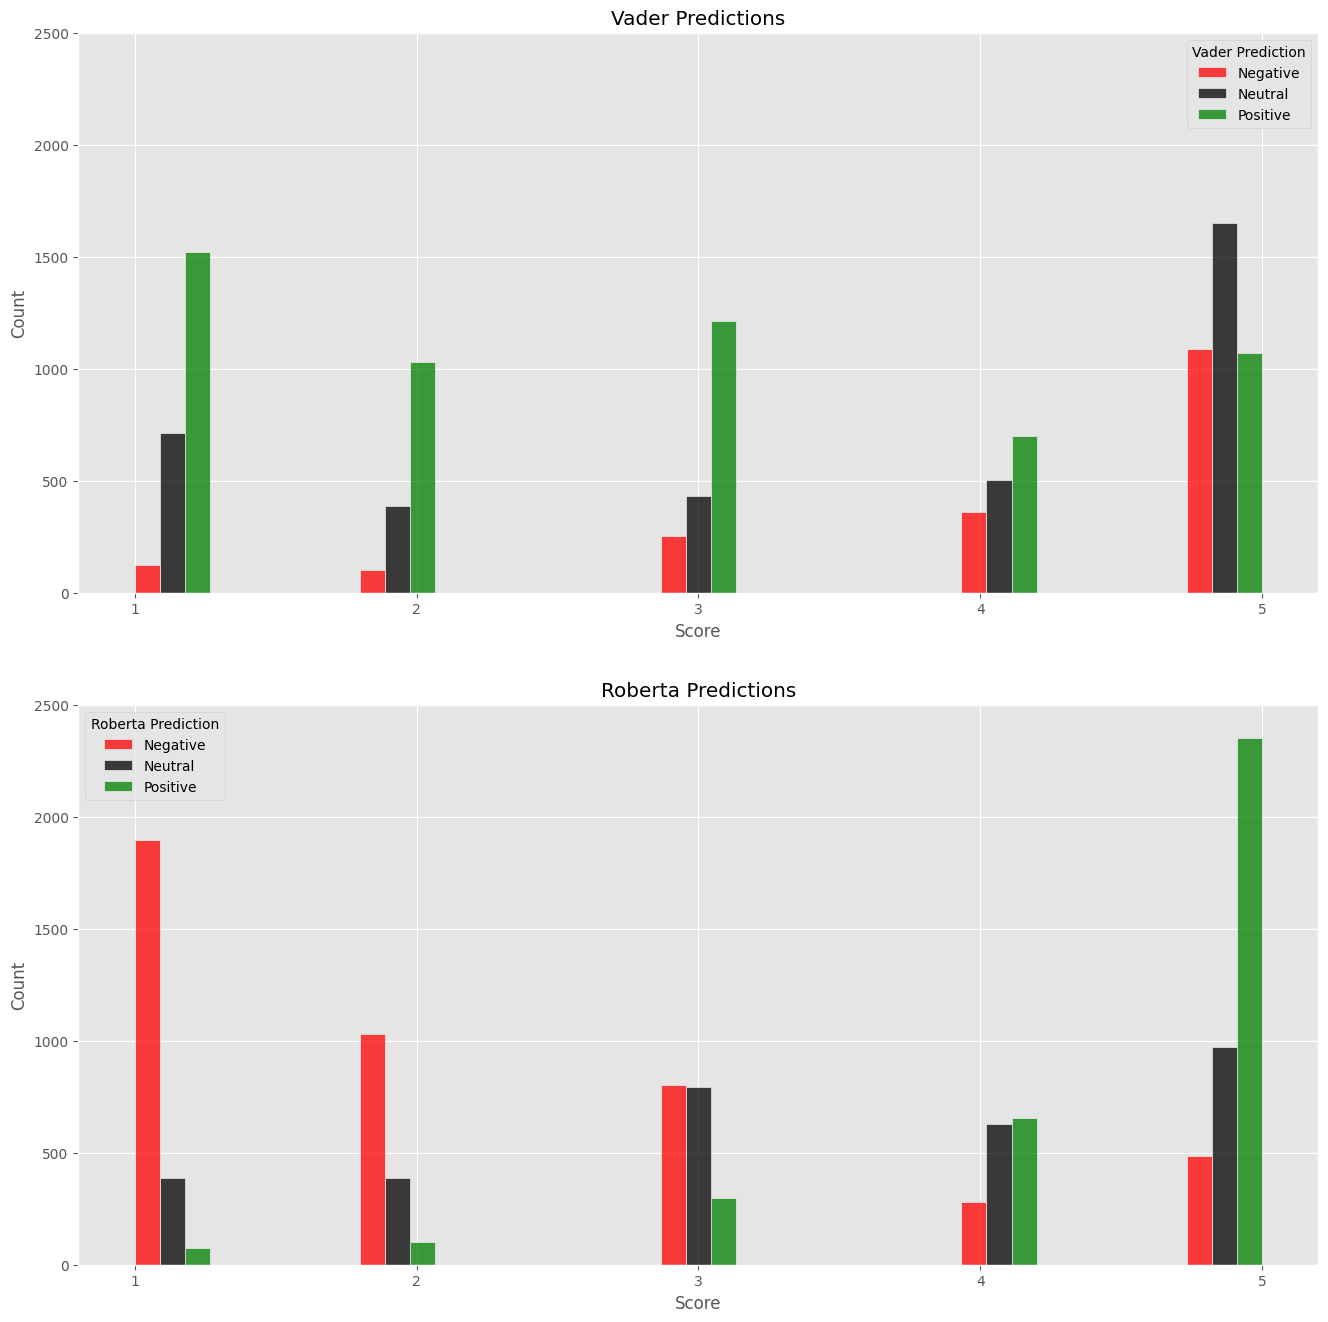

In [48]:
plt.figure(figsize=(16,16))
custom = {"Positive": "green", "Neutral": "black", "Negative": "red"}
bin_edges = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
order = ['Negative', 'Neutral', 'Positive']

plt.subplot( 2, 1, 1)
sns.histplot( x='Score', data=predictions, hue='Vader Prediction', multiple='dodge', palette=custom, hue_order=order)
plt.title('Vader Predictions')
plt.xticks([1, 2, 3, 4, 5])
plt.ylim(0,2500)

plt.subplot( 2, 1, 2)
sns.histplot( x='Score', data=predictions, hue='Roberta Prediction', multiple='dodge', palette=custom, hue_order=order)
plt.title('Roberta Predictions')
plt.xticks([1, 2, 3, 4, 5])
plt.ylim(0,2500)

plt.show()

### From the above graphs, we can observe that VADER has predicted certain low scores as positive reviews and high scores as neutral reviews, which were correctly predicted by the pre-trained RoBERTa model. Therefore, it is evident that the pre-trained RoBERTa model performs better than the VADER model in the case of complex reviews.

# Sentiment Analysis using ROBERTA PRETRAINED Model

In [42]:
def predict(text):
    scores = roberta_polarity_scores(text)
    neg, neu, pos = scores["roberta_neg"], scores["roberta_neu"], scores["roberta_pos"]

    if max( neg, neu, pos)==neg :
        return "THE STATEMENT IS NEGATIVE"
    elif max( neg, neu, pos)==neu :
        return "THE STATEMENT IS NEUTRAL"
    else :
        return "THE STATEMENT IS POSITIVE"

In [43]:
text = input()
predict(text)

 It was delicious!


'THE STATEMENT IS POSITIVE'